In [15]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt

In [16]:
csv_file_path = '/home/lucas/UFOP/ple_2020/analise_midias_sociais/final-work/data/all_candidates_posts.csv'
df_candidates = pd.read_csv(csv_file_path,encoding = 'utf-8')

In [17]:
# convertendo o tipo data que esta como string em objeto no formato data
df_candidates["created_time"] = pd.to_datetime(df_candidates['created_time'])

In [18]:
df_candidates.head(15)

,created_time,id,message_max_processed,m_m_p_replaced_to_empty,shares,status_type,full_picture,reactions_like,reactions_haha,reactions_wow,reactions_sad,reactions_angry,reactions_love,has_textual_message
0,2019-03-16 21:15:50+00:00,96033897836_10158944569272837,hoje lu comemoramos anos casados ainda apaixon...,hoje lu comemoramos anos casados ainda apaixon...,344,added_photos,https://scontent.fplu2-1.fna.fbcdn.net/v/t1.0-...,15515,21,109,2,10,1524,True
1,2019-03-13 22:09:50+00:00,96033897836_10158937268622837,alunos funcionarios fuzilados escola publica d...,alunos funcionarios fuzilados escola publica d...,120,mobile_status_update,None,2606,2,2,547,6,92,True
2,2019-02-27 13:04:22+00:00,96033897836_10158899426707837,nasceu mateo terceiro filho sophia mario herdo...,nasceu mateo terceiro filho sophia mario herdo...,201,added_photos,https://scontent.fplu2-1.fna.fbcdn.net/v/t1.0-...,7960,32,22,1,2,712,True
3,2019-01-25 23:02:43+00:00,96033897836_10158806072577837,solidariedade familias povo mineiro pensamento...,solidariedade familias povo mineiro pensamento...,27,mobile_status_update,None,1046,1,1,105,1,38,True
4,2018-11-09 00:21:08+00:00,96033897836_10158590520182837,celebrando vida familia agradeco todos felicit...,celebrando vida familia agradeco todos felicit...,108,added_photos,https://scontent.fplu2-1.fna.fbcdn.net/v/t1.0-...,3485,17,8,0,3,306,True
5,2018-10-30 01:28:15+00:00,96033897836_10158561677027837,comecou mal defesa liberdade ficou discurso on...,comecou mal defesa liberdade ficou discurso on...,5174,mobile_status_update,None,14222,2279,108,208,638,1528,True
6,2018-10-29 00:56:57+00:00,96033897836_10158558725992837,hora felicitar todos eleitos faco pessoa presi...,hora felicitar todos eleitos faco pessoa presi...,1031,mobile_status_update,None,10482,98,22,7,18,780,True
7,2018-10-10 20:33:56+00:00,96033897836_10158506125162837,ouvimos ontem todo partido decidimos liberar m...,ouvimos ontem todo partido decidimos liberar m...,193,added_photos,https://scontent.fplu2-1.fna.fbcdn.net/v/t1.0-...,2112,55,18,26,251,225,True
8,2018-10-08 15:25:15+00:00,96033897836_10158499514447837,obrigado todos acreditaram projeto depositaram...,obrigado todos acreditaram projeto depositaram...,402,added_photos,https://scontent.fplu2-1.fna.fbcdn.net/v/t1.0-...,7401,128,9,434,19,615,True
9,2018-10-07 00:00:01+00:00,96033897836_10158493056542837,domingo voce vai escolher presidente voto ajud...,domingo voce vai escolher presidente voto ajud...,383,added_video,https://scontent.fplu2-1.fna.fbcdn.net/v/t15.5...,1935,96,7,3,20,176,True


In [19]:
n_total_posts = len(df_candidates)
print('número total de posts: {0}'.format(str(n_total_posts)))

número total de posts: 21361


In [20]:
n_posts_with_textual_messages = df_candidates[df_candidates.has_textual_message == True].shape[0]
n_posts_without_textual_messages = df_candidates[df_candidates.has_textual_message == False].shape[0]

print('número de posts com mensagens textuais: {0}'.format(str(n_posts_with_textual_messages)))
print('número de posts sem mensagens textuais: {0}'.format(str(n_posts_without_textual_messages)))

número de posts com mensagens textuais: 19589
número de posts sem mensagens textuais: 1772


In [21]:
#============================================================================================
# realizando o tf idf no df['pre_processed_message'] do corpus inteiro
#============================================================================================

# tf idf é uma medida estatística que tem o intuito de indicar a importância de uma palavra 
# de um documento em relação a uma coleção de documentos ou em um corpus linguístico.

def sort_columns(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_top_n_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

cv = CountVectorizer()

word_count_vector=cv.fit_transform(df_candidates['m_m_p_replaced_to_empty'])

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names()

# get the document that we want to extract keywords from
corpus=' '.join(df_candidates['m_m_p_replaced_to_empty'])

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([corpus]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_columns(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_top_n_from_vector(feature_names,sorted_items,10)

print("\n===Keywords===")
for key in keywords:
    print(key,keywords[key])


===Keywords===
nao 0.242
brasil 0.195
sao 0.189
hoje 0.147
governo 0.129
paulo 0.12
novo 0.118
pais 0.116
sobre 0.116
todos 0.111


In [22]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

nao : 5459
brasil : 4471
sao : 4142
hoje : 3117
governo : 2291
paulo : 2233
sobre : 2124
pais : 2079
novo : 2039
todos : 2012
ser : 1776
estado : 1674
dia : 1668
ja : 1647
presidente : 1489


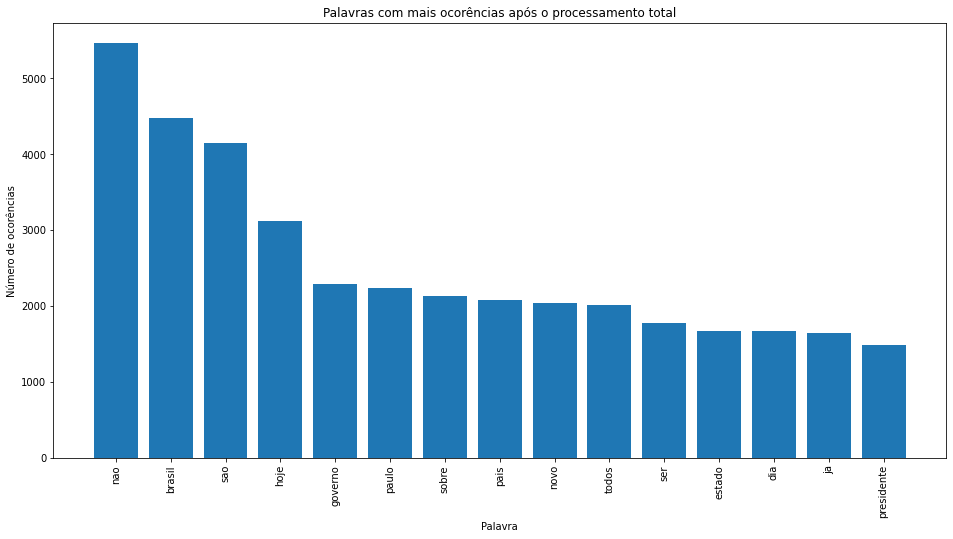

In [14]:
#=======================================================================
# visualização das top palavras
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_candidates['m_m_p_replaced_to_empty'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências após o processamento total');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()
